In [1]:
# make a flattened copy of the cells passed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def flatten_df(df, loval, hival, nbins, column, i0=0, i1=-1, _print=False, _scatter=False, copy=False):
    ''' return (df, cnts) '''
    if copy:
        df = df.copy()

    bins = np.linspace(loval, hival, nbins+1)
    cnts, edges = np.histogram(df[column], bins=bins)

    min_val = np.min(cnts[i0:i1][cnts[i0:i1]>0])
    ratio_kept = np.where(cnts > 0, min_val / cnts, 0.)

    if _print:
        print(f'col: {column}, range: {loval}-{hival}, cnts: {cnts}')
        print(f'ratio_cut {ratio_kept}')

    if _scatter:
        plt.scatter((edges[:-1]+edges[1:])*0.5, cnts, label='Before Cut')

    bin_width = (hival - loval) / nbins
    def keep_event(val):
        if (val < loval) or (val >= hival): 
            return False
        index = int((val-loval)/bin_width)
        if (index == nbins):
            print(f'val: {val}, loval: {loval}, hival: {hival}, index: {index}, nbins: {nbins}')
        cut_ratio = ratio_kept[index]
        if (cut_ratio > 1.):
            return True
        else:
            return (np.random.rand() < cut_ratio)


    keep = df.apply(lambda x: keep_event(x[column]), axis=1, result_type='reduce' )
    df = df[keep].reset_index(drop=True)

    cnts, edges = np.histogram(df[column], bins=bins)
    if _print:
        print(f'counts: {cnts}')
        print(f'bins: {bins}')
        print(f'edges: {edges}')
    if _scatter:
        plt.scatter((edges[:-1]+edges[1:])*0.5, cnts, label='after cut')
        plt.xlabel(column)
        plt.ylabel('Num. Events')
        plt.yscale('log')
        plt.legend()

    return (cnts, df)




/home/davidstewart/penv-ML/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/davidstewart/penv-ML/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
# import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the parquet file
try:
    df = pd.read_parquet('../config/threep5_lbt/gz_files/IP_match_trees/hadd.parquet')
except Exception as e:
    print(f"Error: {e}")
    exit()

FRACTION=1.00
SEED=1
df = df.sample(frac=FRACTION, random_state=SEED)

df = df[(df.matched_TtoR==1) & (df.matched_IPtoT==1) & (np.abs(df.truth_eta)<0.6)]
# df_in = df_in[df_in.reco_ptlessarea>0.]
print(df.columns)


Index(['matched_IPtoT', 'matched_TtoR', 'dR_IPtoT', 'dR_TtoR', 'IP_pt',
       'IP_eta', 'IP_phi', 'resid_rhoA', 'Xsec', 'XsecSigma',
       'rho_bkg_thermal', 'rho_bkg_thermalandjet', 'truth_pt', 'truth_phi',
       'truth_eta', 'truth_isleadjet', 'truth_charge', 'truth_nconsts',
       'truth_C0_pt', 'truth_C1_pt', 'truth_C2_pt', 'truth_C3_pt',
       'truth_C4_pt', 'truth_C5_pt', 'truth_C6_pt', 'truth_C7_pt',
       'truth_C8_pt', 'truth_C9_pt', 'reco_pt', 'reco_phi', 'reco_eta',
       'reco_isleadjet', 'reco_area', 'reco_charge', 'reco_nconsts',
       'reco_angularity', 'reco_C0_pt', 'reco_C1_pt', 'reco_C2_pt',
       'reco_C3_pt', 'reco_C4_pt', 'reco_C5_pt', 'reco_C6_pt', 'reco_C7_pt',
       'reco_C8_pt', 'reco_C9_pt'],
      dtype='object')


0.200008
86.10576
0.9817190177254251
29805493
555020


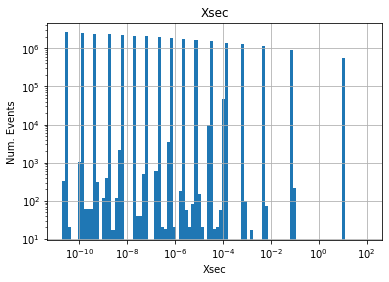

In [3]:
# plot Xsec vs truth_pt and remove outliers
print(df.truth_pt.min())
print(df.truth_pt.max())
bins_y = np.logspace(np.log10(df['Xsec'].min()), 2, 100)
bins = np.linspace(0., 2., 100)
df.hist(column='Xsec', bins=bins_y)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Num. Events')
plt.xlabel('Xsec')

nbelow = df[df.Xsec<1.].shape[0]
nabove = df[df.Xsec>1.].shape[0]
print(nbelow/(nbelow+nabove))

print(df[df.Xsec<1.].shape[0])
print(df[df.Xsec>1.].shape[0])

df = df[df.Xsec<1.].reset_index(drop=True)

(49, 99)


/tmp/ipykernel_334988/3619218044.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('Xsec_bin')['truth_pt']


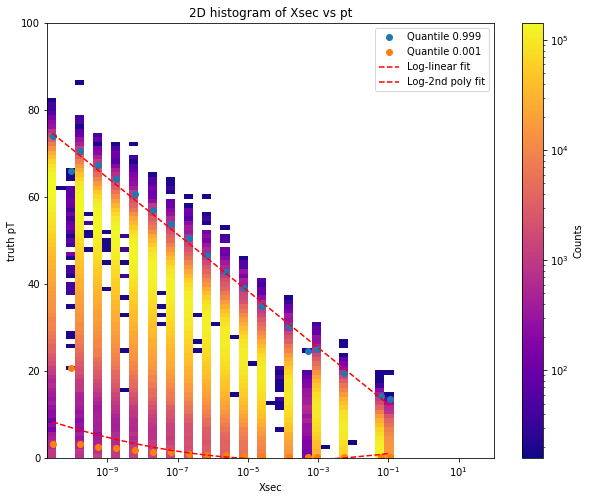

In [4]:
# draw Xsec vs IP_match
from matplotlib.colors import LogNorm

# df = df_flat_pt
plt.figure(figsize=(10, 8))
bins_xsec = np.logspace(np.log10(df['Xsec'].min()), 2, 50)
bins_truth_pt = np.linspace(0., 100., 100)
counts, xedges, yedges, im = plt.hist2d(df['Xsec'], df['truth_pt'], bins=[bins_xsec, bins_truth_pt], cmap='plasma', norm=LogNorm())
plt.colorbar(im, label='Counts')
plt.xlabel('Xsec')
plt.ylabel('truth pT')
plt.xscale('log')
plt.title('2D histogram of Xsec vs pt')

ymax = 1e-2

print(counts.shape)
x_cen = (xedges[:-1] + xedges[1:])/2
y_cen = (yedges[:-1] + yedges[1:])/2

# print(np.sum(counts[:,0]))
# print(counts[1,:])

df['Xsec_bin'] = pd.cut(df['Xsec'],bins=bins_xsec, labels=x_cen)
grouped = df.groupby('Xsec_bin')['truth_pt']
truth_pt_arrays = [group for name, group in grouped]
# print(len(truth_pt_arrays))
# print([i,len(truth_pt_arrays[0])])
# print([i,len(truth_pt_arrays[1])])
# plt.xlim([0, 70])  # set x-axis limits
# plt.ylim([0, ymax])  # set y-axis limits

pUp = 0.999
xUp = []
yUp = []

pLo = 0.001
xLo = []
yLo = []

for i, group in enumerate(truth_pt_arrays):
    if len(group) < 1000:
        continue

    pcen = np.quantile(group, pUp)
    xUp.append(x_cen[i])
    yUp.append(pcen)

    pcen = np.quantile(group, pLo)
    xLo.append(x_cen[i])
    yLo.append(pcen)

plt.scatter(xUp, yUp,label='Quantile 0.999')
plt.xscale('log')

plt.scatter(xLo, yLo,label='Quantile 0.001')
plt.xscale('log')


xUp_linear = np.log(xUp)
coefUp = np.polyfit(xUp_linear, yUp, 1)
yUp_fit = np.polyval(coefUp, xUp_linear)
plt.plot(xUp, yUp_fit,  'r--', label='Log-linear fit')

xLo_linear = np.log(xLo)
coefLo = np.polyfit(xLo_linear, yLo, 2)
yLo_fit = np.polyval(coefLo, xLo_linear)
plt.plot(xLo, yLo_fit,  'r--', label='Log-2nd poly fit')



plt.legend()
plt.show()


In [5]:
# cut the outliers defined by the coefficients
passUp = df['truth_pt'] < np.polyval(coefUp, np.log(df['Xsec']))
passLo = df['truth_pt'] > np.polyval(coefLo, np.log(df['Xsec']))
df = df[passUp & passLo]

Text(0.5, 1.0, '2D histogram of Xsec vs pt')

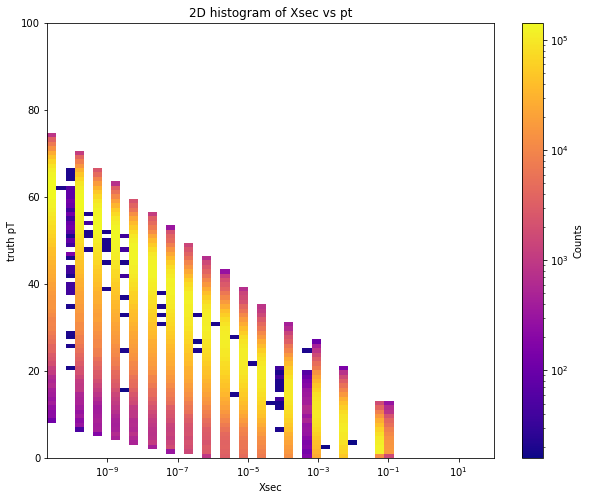

In [6]:
# plot again
# df = df_flat_pt
plt.figure(figsize=(10, 8))
bins_xsec = np.logspace(np.log10(df['Xsec'].min()), 2, 50)
bins_truth_pt = np.linspace(0., 100., 100)
counts, xedges, yedges, im = plt.hist2d(df['Xsec'], df['truth_pt'], bins=[bins_xsec, bins_truth_pt], cmap='plasma', norm=LogNorm())
plt.colorbar(im, label='Counts')
plt.xlabel('Xsec')
plt.ylabel('truth pT')
plt.xscale('log')
plt.title('2D histogram of Xsec vs pt')

Text(0.5, 1.0, '2D histogram of Xsec vs pt')

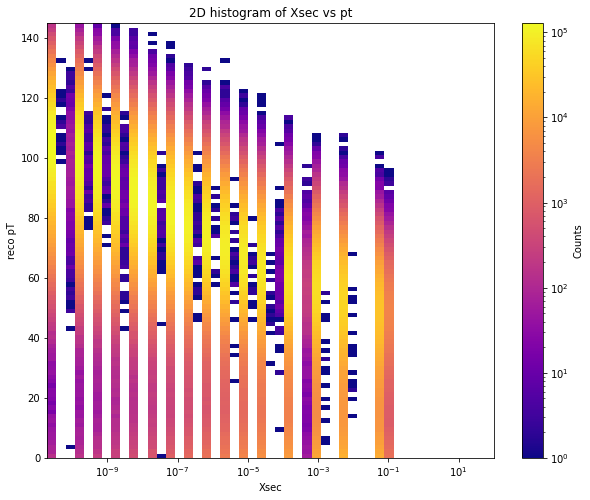

In [7]:
# plot again
# df = df_flat_pt
plt.figure(figsize=(10, 8))
bins_xsec = np.logspace(np.log10(df['Xsec'].min()), 2, 50)
bins_truth_pt = np.linspace(0., 145., 100)
counts, xedges, yedges, im = plt.hist2d(df['Xsec'], df['reco_pt'], bins=[bins_xsec, bins_truth_pt], cmap='plasma', norm=LogNorm())
plt.colorbar(im, label='Counts')
plt.xlabel('Xsec')
plt.ylabel('reco pT')
plt.xscale('log')
plt.title('2D histogram of Xsec vs pt')

/tmp/ipykernel_334988/3376422368.py:16: RuntimeWarning: divide by zero encountered in divide
  ratio_kept = np.where(cnts > 0, min_val / cnts, 0.)


col: IP_pt, range: 2.0-68.0, cnts: [      0   21212  342836  340045  519919  473565  625193  569558  715464
  651532  809058  734227  886947  807874  954221  871742 1023225  930610
 1073228  988219 1115555 1053066 1157850 1105964 1188213 1193232 1218919
 1268015 1236317 1350799 1241489 1455612]
ratio_cut [ 0.         16.03078446  0.99185908  1.          0.65403457  0.71805349
  0.54390404  0.59703314  0.47527898  0.52191604  0.42029743  0.46313334
  0.38338818  0.42091341  0.35635875  0.39007527  0.33232671  0.36540011
  0.31684321  0.34409883  0.30482137  0.32290949  0.29368657  0.3074648
  0.28618185  0.28497811  0.2789726   0.26817112  0.27504677  0.25173619
  0.27390094  0.23360964]
counts: [     0  21212 340032 340045 340490 339464 340140 339792 341304 340056
 340102 340597 340938 339309 340228 340230 339902 340467 340012 339527
 339794 339048 339572 339480 340182 340716 340174 340250 339662 340418
 339976 340877]
bins: [ 2.      4.0625  6.125   8.1875 10.25   12.3125 14.375  16.4

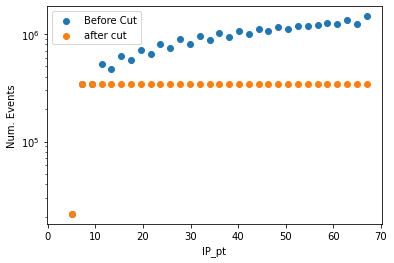

In [9]:

# bins = np.linspace(0., 70., 71)
# cnts, edges = np.histogram(df.init_parton_pt, bins=bins)
# plt.scatter((edges[:-1]+edges[1:])*0.5, cnts)


_, df_flatinit = flatten_df(df, 2., 68., 32, 'IP_pt', _print=True, _scatter=True, copy=True, i0=2, i1=-1)
df_flatinit.to_parquet('flat_IP_pt.parquet')

In [9]:
print(np.max(df_flatinit.Xsec))

0.601965


col: truth_pt, range: 0.0-60.0, cnts: [281501 442319 446410 423765 397007 383255 379549 378270 376445 373636
 370887 367976 362377 359318 355663 350908 342968 338493 330177 324428
 317340 308424 301571 289933 277046 264362 243968 220293 188973 156731]
ratio_cut [0.55676889 0.35433929 0.35109205 0.36985357 0.39478145 0.40894705
 0.41294009 0.41433632 0.41634502 0.4194751  0.42258424 0.42592723
 0.43250813 0.43619023 0.44067277 0.44664413 0.45698433 0.46302582
 0.47468782 0.48309949 0.49388983 0.50816733 0.51971509 0.54057662
 0.56572194 0.59286509 0.64242442 0.71146609 0.82938303 1.        ]
counts: [156368 156161 156748 156702 156382 156952 157291 156547 157172 156943
 156623 156796 156674 156843 156877 156257 156768 156564 156941 156569
 156695 156660 157119 156768 156748 156799 156944 156648 157036 156731]
bins: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48. 50. 52. 54. 56. 58. 60.]
edges: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.

Text(10, 80000.0, 'Wider bins because 0-1 GeV have so few events')

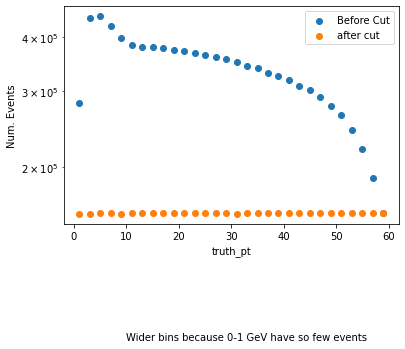

In [10]:
# Plot the reco_pt_truthconst spectra
import matplotlib.colors as colors


_, df_flat_pt = flatten_df(df_flatinit, 0., 60., 30, 'truth_pt', _print=True, _scatter=True, copy=True, i0=1,i1=30)
df_flat_pt.to_parquet('flat_truth_pt.parquet')
plt.text(x=10,y=8e4,s="Wider bins because 0-1 GeV have so few events")

# bins = np.linspace(0., 70., 71)
# cnts, edges = np.histogram(df_flatinit.truth_pt, bins=bins)
# plt.scatter((edges[:-1]+edges[1:])*0.5, cnts)
# plt.xlabel('truth_pt')
# plt.ylabel('Num. Events')

#plot 2D histogram of reco_pt_truthconst vs init_parton_pt
# plt.figure()
# plt.hist2d(df_flat_pt.IP_pt, df_flat_pt.truth_pt, bins=(bins, bins), cmap='plasma', norm=colors.LogNorm())
# plt.xlabel('IP pT')
# plt.ylabel('truth pT')    
# plt.colorbar()

# hibins = np.linspace(0., 170., 71)
# plt.figure()
# plt.hist2d(df_flat_pt.IP_pt, df_flat_pt.reco_pt, bins=(bins, hibins), cmap='plasma', norm=colors.LogNorm())
# plt.xlabel('IP pT')
# plt.ylabel('reco pT')    
# plt.colorbar()

array([[<AxesSubplot:title={'center':'IP_pt'}>]], dtype=object)

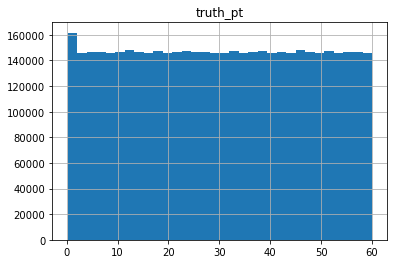

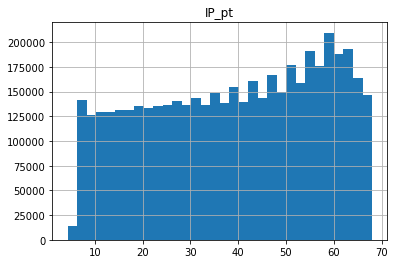

In [11]:
df_flat_pt.hist(column='truth_pt', bins=32)
df_flat_pt.hist(column='IP_pt', bins=32)

0.10027


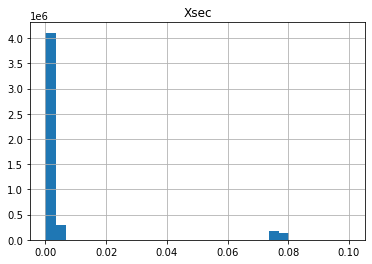

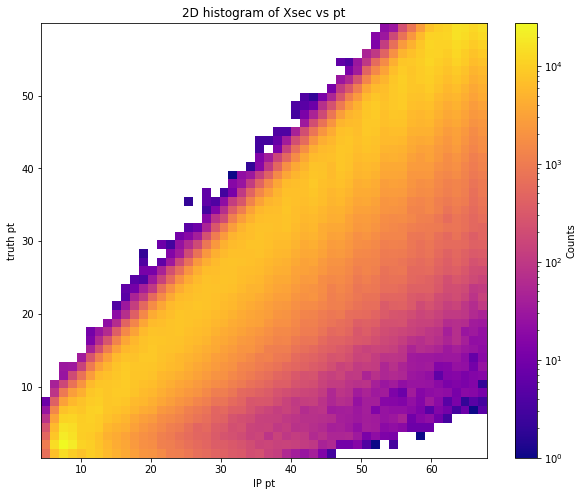

In [12]:
#plot 2D histogram of reco_pt_truthconst vs init_parton_pt
# df.hist(Xsec)
print(np.max(df_flat_pt.Xsec))
df_flat_pt.hist(column='Xsec', bins=30)
# plt.figure()
# plt.hist2d(df_flat_pt.IP_pt, df_flat_pt.truth_pt, bins=(bins, bins), cmap='plasma', norm=colors.LogNorm())
# plt.xlabel('IP pT')
# plt.ylabel('truth pT')    
# plt.colorbar()import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

df = df_flat_pt
plt.figure(figsize=(10, 8))

Xsec_max = 1

bins_y = np.logspace(np.log10(df['Xsec'].min()), Xsec_max, 100)

counts, xedges, yedges, im = plt.hist2d(df['IP_pt'], df['truth_pt'], bins=[50, 50], cmap='plasma', norm=LogNorm())
plt.colorbar(im, label='Counts')
plt.xlabel('IP pt')
plt.ylabel('truth pt')
# plt.yscale('log')
plt.title('2D histogram of Xsec vs pt')

ymax = 1e-2

# plt.xlim([0, 70])  # set x-axis limits
# plt.ylim([0, ymax])  # set y-axis limits
plt.show()

now
130


/tmp/ipykernel_334988/1239090382.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_reco = df.groupby('truth_pt_bin')['reco_pt']
/tmp/ipykernel_334988/1239090382.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_truth = df.groupby('reco_pt_bin')['truth_pt']


['len reco_pt_arrays:', 60]
['len truth_pt_arrays:', 130]
60
130


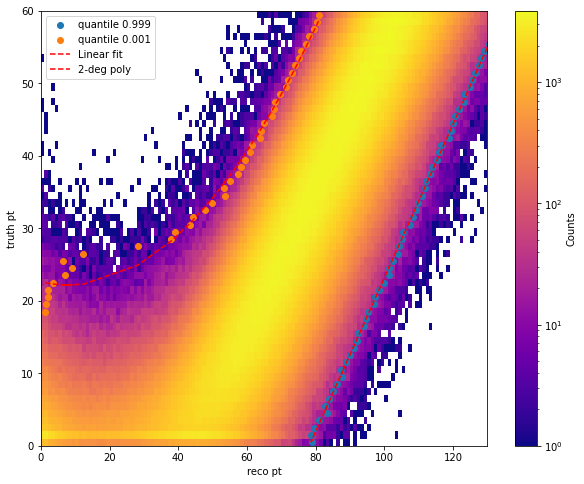

In [13]:
# plot again
df = df_flat_pt
plt.figure(figsize=(10, 8))
# bins_xsec = np.logspace(np.log10(df['Xsec'].min()), 2, 50)
# bins_truth_pt = np.linspace(0., 100., 100)
bins_truth = np.linspace(0., 60., 61)
bins_reco  = np.linspace(0., 130., 131)
counts, xedges, yedges, im = plt.hist2d(df['reco_pt'], df['truth_pt'], bins=[bins_reco, bins_truth], cmap='plasma', norm=LogNorm())
plt.colorbar(im, label='Counts')
plt.xlabel('reco pt')
plt.ylabel('truth pt')


x_cen = (xedges[1:]+xedges[:-1])/2.
print('now')
print(len(x_cen))
y_cen = (yedges[1:]+yedges[:-1])/2.


df['truth_pt_bin'] = pd.cut(df['truth_pt'],bins=bins_truth)
df['reco_pt_bin']  = pd.cut(df['reco_pt'], bins=bins_reco)

group_reco = df.groupby('truth_pt_bin')['reco_pt']
reco_pt_arrays = [group for name, group in group_reco]
print(['len reco_pt_arrays:', len(reco_pt_arrays)])

group_truth = df.groupby('reco_pt_bin')['truth_pt']
truth_pt_arrays = [group for name, group in group_truth]
print(['len truth_pt_arrays:', len(truth_pt_arrays)])


print(len(reco_pt_arrays))
print(len(truth_pt_arrays))
# print(reco_pt_arrays[0])

pRecoUp = 0.999
xRecoUp = []
yRecoUp = []

pRecoLo = 0.001
xRecoLo = []
yRecoLo = []


for i, group in enumerate(reco_pt_arrays):
    if len(group) < 1000:
        continue
    pUp = np.quantile(group, pRecoUp)
    yRecoUp.append(y_cen[i])
    xRecoUp.append(pUp)

    if i > 17:
        pLo = np.quantile(group, pRecoLo)
        yRecoLo.append(y_cen[i])
        xRecoLo.append(pLo)

plt.scatter(xRecoUp, yRecoUp,label='quantile 0.999')
plt.scatter(xRecoLo, yRecoLo,label='quantile 0.001')

coefUp = np.polyfit(xRecoUp, yRecoUp, 1)
yUp_fit = np.polyval(coefUp, xRecoUp)
plt.plot(xRecoUp, yUp_fit,  'r--', label='Linear fit')

coefLo = np.polyfit(xRecoLo, yRecoLo, 2)
yLo_fit = np.polyval(coefLo, xRecoLo)
plt.plot(xRecoLo, yLo_fit,  'r--', label='2-deg poly')
plt.legend()



Text(0, 0.5, 'truth pt')

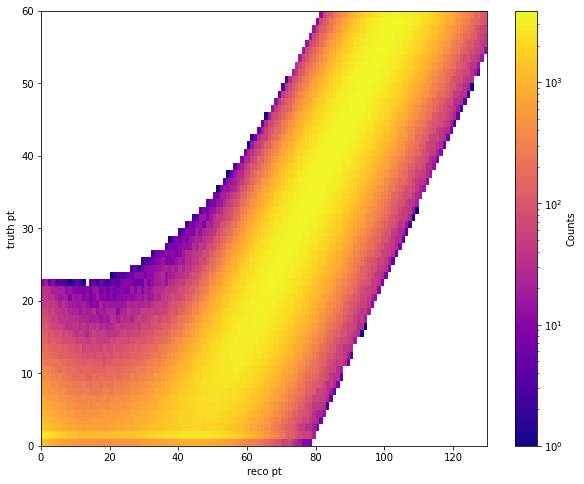

In [14]:
# make the final cut
# print(df.describe())
cut_hi = df['truth_pt'] > np.polyval(coefUp, df['reco_pt'])
cut_lo = df['truth_pt'] < np.polyval(coefLo, df['reco_pt'])

df_fin = df[cut_hi & cut_lo]

plt.figure(figsize=(10, 8))
bins_truth = np.linspace(0., 60., 61)
bins_reco  = np.linspace(0., 130., 131)
counts, xedges, yedges, im = plt.hist2d(df_fin['reco_pt'], df_fin['truth_pt'], bins=[bins_reco, bins_truth], cmap='plasma', norm=LogNorm())
plt.colorbar(im, label='Counts')
plt.xlabel('reco pt')
plt.ylabel('truth pt')



# # pTruthUp = 0.999
# # xTruthUp = []
# # yTruthUp = []

# # for i, group in enumerate(truth_pt_arrays):
# #     if i > 86:
# #         continue
# #     if len(group) < 10:
# #         continue
# #     pcen = np.quantile(group, pTruthUp)
# #     yTruthUp.append(pcen)
# #     xTruthUp.append(x_cen[i])


# # xUp_fit = np.polyval(coefUp, yUp)
# # plt.plot(xUp_fit, yUp,  'r--', label='Log-linear fit')

# # set limits on the reco pt w.r.t. truth pt


In [15]:
print(df_fin.columns)
for c in df_fin.columns:
    if c.endswith('_bin'):
        print(c)
        df_fin.drop(columns=[c], inplace=True)
df_fin.to_parquet('min_bias_input.parquet')

Index(['matched_IPtoT', 'matched_TtoR', 'dR_IPtoT', 'dR_TtoR', 'IP_pt',
       'IP_eta', 'IP_phi', 'resid_rhoA', 'Xsec', 'XsecSigma',
       'rho_bkg_thermal', 'rho_bkg_thermalandjet', 'truth_pt', 'truth_phi',
       'truth_eta', 'truth_isleadjet', 'truth_charge', 'truth_nconsts',
       'truth_C0_pt', 'truth_C1_pt', 'truth_C2_pt', 'truth_C3_pt',
       'truth_C4_pt', 'truth_C5_pt', 'truth_C6_pt', 'truth_C7_pt',
       'truth_C8_pt', 'truth_C9_pt', 'reco_pt', 'reco_phi', 'reco_eta',
       'reco_isleadjet', 'reco_area', 'reco_charge', 'reco_nconsts',
       'reco_angularity', 'reco_C0_pt', 'reco_C1_pt', 'reco_C2_pt',
       'reco_C3_pt', 'reco_C4_pt', 'reco_C5_pt', 'reco_C6_pt', 'reco_C7_pt',
       'reco_C8_pt', 'reco_C9_pt', 'Xsec_bin', 'truth_pt_bin', 'reco_pt_bin'],
      dtype='object')
Xsec_bin
truth_pt_bin


/tmp/ipykernel_334988/1087401022.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fin.drop(columns=[c], inplace=True)
/tmp/ipykernel_334988/1087401022.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fin.drop(columns=[c], inplace=True)


reco_pt_bin


/tmp/ipykernel_334988/1087401022.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fin.drop(columns=[c], inplace=True)


Text(0, 0.5, 'truth pt')

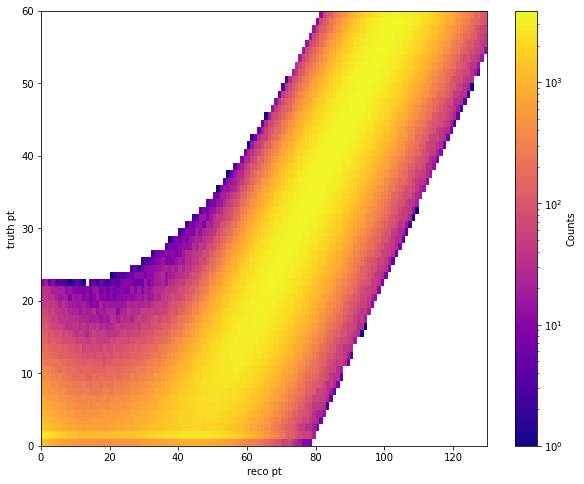

In [16]:
test = pd.read_parquet('min_bias_input.parquet')
plt.figure(figsize=(10, 8))
bins_truth = np.linspace(0., 60., 61)
bins_reco  = np.linspace(0., 130., 131)
counts, xedges, yedges, im = plt.hist2d(test['reco_pt'], test['truth_pt'], bins=[bins_reco, bins_truth], cmap='plasma', norm=LogNorm())
plt.colorbar(im, label='Counts')
plt.xlabel('reco pt')
plt.ylabel('truth pt')

Index(['matched_IPtoT', 'matched_TtoR', 'dR_IPtoT', 'dR_TtoR', 'IP_pt',
       'IP_eta', 'IP_phi', 'resid_rhoA', 'Xsec', 'XsecSigma',
       'rho_bkg_thermal', 'rho_bkg_thermalandjet', 'truth_pt', 'truth_phi',
       'truth_eta', 'truth_isleadjet', 'truth_charge', 'truth_nconsts',
       'truth_C0_pt', 'truth_C1_pt', 'truth_C2_pt', 'truth_C3_pt',
       'truth_C4_pt', 'truth_C5_pt', 'truth_C6_pt', 'truth_C7_pt',
       'truth_C8_pt', 'truth_C9_pt', 'reco_pt', 'reco_phi', 'reco_eta',
       'reco_isleadjet', 'reco_area', 'reco_charge', 'reco_nconsts',
       'reco_angularity', 'reco_C0_pt', 'reco_C1_pt', 'reco_C2_pt',
       'reco_C3_pt', 'reco_C4_pt', 'reco_C5_pt', 'reco_C6_pt', 'reco_C7_pt',
       'reco_C8_pt', 'reco_C9_pt'],
      dtype='object')
(4694330, 46)
4694330
4694330


(array([368648., 432538., 487604., 524456., 534260., 535593., 523402.,
        487777., 429930., 370122.]),
 array([-5.99998772e-01, -4.79998916e-01, -3.59999031e-01, -2.39999175e-01,
        -1.19999304e-01,  5.66244125e-07,  1.20000437e-01,  2.40000308e-01,
         3.60000163e-01,  4.80000049e-01,  5.99999905e-01], dtype=float32),
 <BarContainer object of 10 artists>)

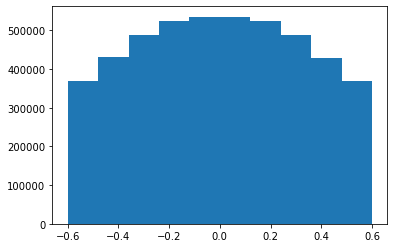

In [17]:
# print(df_fin.describe())
print(df_fin.columns)
print(df_fin.shape)
print(np.sum(df_fin.matched_TtoR))
print(np.sum(df_fin.matched_IPtoT))
plt.hist(df_fin.truth_eta)